<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Técnicas-de-aprendizaje-supervisado" data-toc-modified-id="Técnicas-de-aprendizaje-supervisado-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Técnicas de aprendizaje supervisado</a></span><ul class="toc-item"><li><span><a href="#Practica-de-Intercomparación-aplicada-a-datos-meteorológicos" data-toc-modified-id="Practica-de-Intercomparación-aplicada-a-datos-meteorológicos-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Practica de Intercomparación aplicada a datos meteorológicos</a></span><ul class="toc-item"><li><span><a href="#Santander-Meteorology-Group" data-toc-modified-id="Santander-Meteorology-Group-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Santander Meteorology Group</a></span></li></ul></li></ul></li><li><span><a href="#Conjunto-de-datos-meteo" data-toc-modified-id="Conjunto-de-datos-meteo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Conjunto de datos meteo</a></span></li><li><span><a href="#Árboles-de-clasificación-y-regresión-(2.5-puntos)" data-toc-modified-id="Árboles-de-clasificación-y-regresión-(2.5-puntos)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Árboles de clasificación y regresión (2.5 puntos)</a></span></li><li><span><a href="#Random-forests-(2.5-puntos)" data-toc-modified-id="Random-forests-(2.5-puntos)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Random forests (2.5 puntos)</a></span></li><li><span><a href="#Modelos-lineales-generalizados-(GLMs)-(1.5-puntos)" data-toc-modified-id="Modelos-lineales-generalizados-(GLMs)-(1.5-puntos)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelos lineales generalizados (GLMs) (1.5 puntos)</a></span></li><li><span><a href="#k-nearest-neighbors-(k-NN)-(1.5-puntos)" data-toc-modified-id="k-nearest-neighbors-(k-NN)-(1.5-puntos)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>k nearest neighbors (k-NN) (1.5 puntos)</a></span></li><li><span><a href="#Conclusiones-generales-(2-puntos)" data-toc-modified-id="Conclusiones-generales-(2-puntos)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusiones generales (2 puntos)</a></span></li></ul></div>

# Minería de Datos (Master en Data Science, UIMP-UC)

## Técnicas de aprendizaje supervisado

### Practica de Intercomparación aplicada a datos meteorológicos

#### Santander Meteorology Group

En esta práctica haremos una intercomparación de varias de las técnicas de aprendizaje supervisado vistas a lo largo de la asignatura (CART, k-NN, GLMs y Random Forests). Por tanto, pretende ser un repaso general de cara al examen en el que el objetivo es tratar de entender las ventajas y limitaciones de las distintas técnicas para un caso de aplicación particular; la predicción de precipitación. La entrega consistirá en un notebook (Jupyter o R-Markdown), junto con el archivo html que éste genera. Ambos ficheros se entregarán a través del Moodle de la asignatura en la tarea correspondiente.

## Conjunto de datos meteo

Comenzaremos cargando el dataset meteo, que ya ha sido utilizado en sesiones anteriores. Como ya sabéis, la variable objetivo en este dataset es la precipitation diaria en Lisboa durante el período 1979-2008, y para modelizar ésta se dispone de un conjunto de 8 variables meteorológicas predictoras que describen la circulación de larga escala definidas sobre un dominio geográfico que incluye 40 puntos sobre la Península Ibérica. (en total 8×40=320 variables explicativas). Las variables predictoras son:

* altura geopotencial en 500 hPa (Z500)
* temperatura del aire en 850 hPa, 700 hPa, 500 hPa (ta850, ta700 y ta500), y en superficie (tas)
* humedad específica del aire en 850 hPa y 500 hPa (hus850, hus500)
* presión a nivel del mar (psl)

Para agilizar los tiempos de cómputo, reduciremos la dimensionalidad del problema. Como ya se ha visto en sesiones anteriores, una alternativa para tal fin es el uso de PCs. Sin embargo, para no limitar la interpretabilidad de los resultados obtenidos con árboles, utilizaremos otra aproximación aquí. En concreto, optaremos por un análisis de correlaciones, en el que se calcula la correlación de Spearman entre nuestra variable objetivo y todas las variables predictoras disponibles. La asunción de partida es que cuanto más fuerte sea esta correlación, mayor es el vínculo físico entre predictando y predictor, y por tanto, más útil es la información que nos aporta ese predictor. Por tanto, este análisis nos permite descartar predictores poco relevantes. Siguiendo esta idea, calcularemos la correlación existente entre nuestro predictando y los 320 predictores, y eliminaremos aquellos con correlaciones entre -0.4 y 0.4. ¿Cuánto se ha reducido la dimensionalidad del problema?

In [70]:
library(tree)
library(caret)

In [3]:
load("meteo.RData")
str(x)
str(y)

 num [1:10958, 1:320] 57043 56963 56523 54628 53584 ...
 num [1:10958, 1] 10.9 0.6 13 0 0 1.2 1.1 0 0 0.7 ...


In [4]:
# Spearman correlations
correlations <- apply(x, 2, function(col) cor(y, col, method = "spearman"))
head(correlations)

[1] -0.4240867 -0.4798011 -0.5266560 -0.5580364 -0.5683502 -0.4068752

In [5]:
# Filter predictors with correlation < -0.4 or > 0.4
selected_predictors <- x[, correlations < -0.4 | correlations > 0.4]
dim(selected_predictors)

[1] 10958    37

In [6]:
original_count <- ncol(x)
filtered_count <- ncol(selected_predictors)
reduction <- (original_count - filtered_count) / original_count * 100

cat("Original number of predictors:", original_count, "\n")
cat("Number of predictors after filtering:", filtered_count, "\n")
cat("Dimensionality reduction:", round(reduction, 2), "%\n")

Original number of predictors: 320 
Number of predictors after filtering: 37 
Dimensionality reduction: 88.44 %


Para simplificar aún más los cálculos, nos limitaremos a los primeros 5000 días del dataset. Como siempre, consideraremos una partición de la muestra en dos subconjuntos independientes, train y test, escogidos aleatoriamente (75% para entrenar y 25% para validar).

## Árboles de clasificación y regresión (2.5 puntos)

Como ya hemos visto en sesiones anteriores, tendremos que crear dos modelos independientes, uno para la clasificación del evento binario lluvia/no lluvia y otro para el evento continuo cantidad de lluvia. Nos centramos en primer lugar en la clasificación lluvia/no lluvia. Para ello, tenemos que crear la variable binaria ocurrencia de precipitación (considera un umbral de 1 mm) y construir el dataframe asociado al problema.

A continuación construiremos el árbol completo (usa la función tree). ¿Cuántos nodos terminales obtienes? ¿Qué variables predictoras dan lugar a las primeras subdivisiones del árbol?

# <font color="cyan"> Classification

## <font color="purple"> Full tree

In [7]:
# Limit dataset to the first 5000 days
x_subset <- selected_predictors[1:5000, ]
y_subset <- y[1:5000]

# Create a binary variable: 1 if rain >= 1 mm, 0 otherwise
rain_binary <- ifelse(y_subset >= 1, 1, 0)

set.seed(123)

train_indices <- sample(1:nrow(x_subset), size = 0.75 * nrow(x_subset))

# Split the data into train and test
x_train <- x_subset[train_indices, ]
x_test <- x_subset[-train_indices, ]
y_train <- rain_binary[train_indices]
y_test <- rain_binary[-train_indices]

# Combine predictors and binary target into a dataframe
train_data <- data.frame(rain = factor(y_train), x_train)
test_data <- data.frame(rain = factor(y_test), x_test)

cat("Training set dimension:", dim(x_train), "\n")
cat("Test set dimension:", dim(x_test), "\n")

Training set dimension: 3750 37 
Test set dimension: 1250 37 



Classification tree:
tree(formula = rain ~ ., data = train_data, mincut = 1, minsize = 2, 
    mindev = 0)
Variables actually used in tree construction:
 [1] "X28" "X27" "X35" "X3"  "X7"  "X4"  "X11" "X25" "X15" "X2"  "X12" "X22"
[13] "X21" "X16" "X23" "X1"  "X6"  "X30" "X8"  "X5"  "X17" "X14" "X9"  "X32"
[25] "X29" "X37" "X26" "X10" "X13" "X18" "X20" "X19" "X34" "X31" "X36" "X33"
Number of terminal nodes:  292 
Residual mean deviance:  0 = 0 / 3458 
Misclassification error rate: 0 = 0 / 3750 

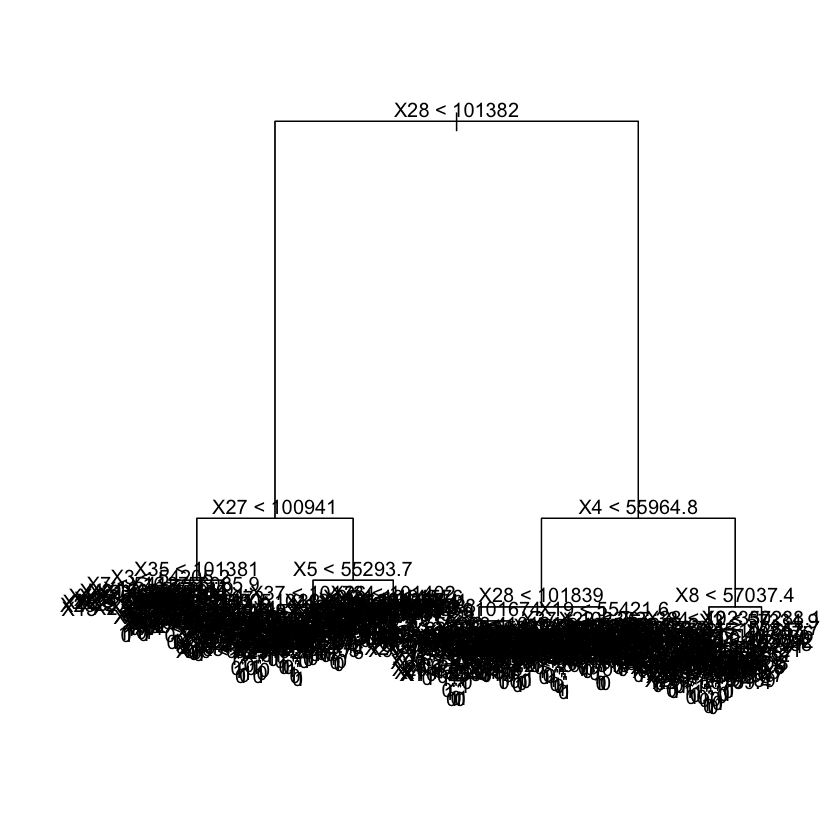

In [8]:
# Build the classification tree
binary_tree <- tree(rain ~ ., data = train_data, mincut = 1, minsize = 2, mindev = 0)

# Summary of the tree
summary(binary_tree)

# Plot the tree
par(bg = "white")
plot(binary_tree)
text(binary_tree, pretty = 0)

The number of terminal nodes obtained with the full tree is 292.

- **X28**: This variable is used at the root node, providing the first and most significant split in the tree, indicating its high importance in explaining the target variable.
- **X27**: This variable refines predictions on the left branch of the tree after the first split.
- **X4**: This variable refines predictions on the right branch of the tree after the first split.

Para simplificar este árbol tan complejo tendremos que podarlo adecuadamente. Utiliza una cross-validación con un 10-fold para encontrar el número de nodos terminales del árbol óptimo. ¿Cuál es este número? ¿Qué predictores aparecen como los más importantes?

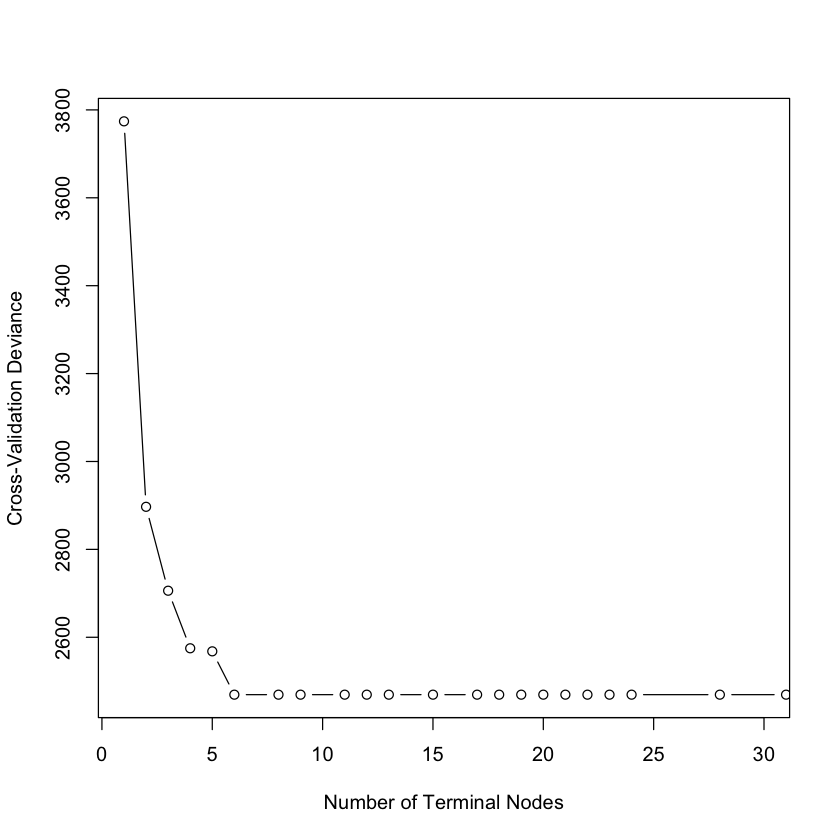

In [9]:
binary_tree_cv <- cv.tree(binary_tree, K = 10)

par(bg = "white")
plot(binary_tree_cv$size, binary_tree_cv$dev, 
     type = "b", 
     xlim = c(1, 30), 
     xlab = "Number of Terminal Nodes", 
     ylab = "Cross-Validation Deviance"
)

From the plot, it is evident that starting from 6 nodes, the deviance does not show significant improvements. This plateau suggests diminishing returns in further increasing the number of nodes. Therefore, I select 6 as the optimal number of nodes for balancing model complexity and performance.

## <font color="purple"> Pruned tree


Classification tree:
snip.tree(tree = binary_tree, nodes = c(15L, 11L, 4L, 10L, 14L, 
6L))
Variables actually used in tree construction:
[1] "X28" "X27" "X5"  "X4"  "X8" 
Number of terminal nodes:  6 
Residual mean deviance:  0.6321 = 2367 / 3744 
Misclassification error rate: 0.1341 = 503 / 3750 

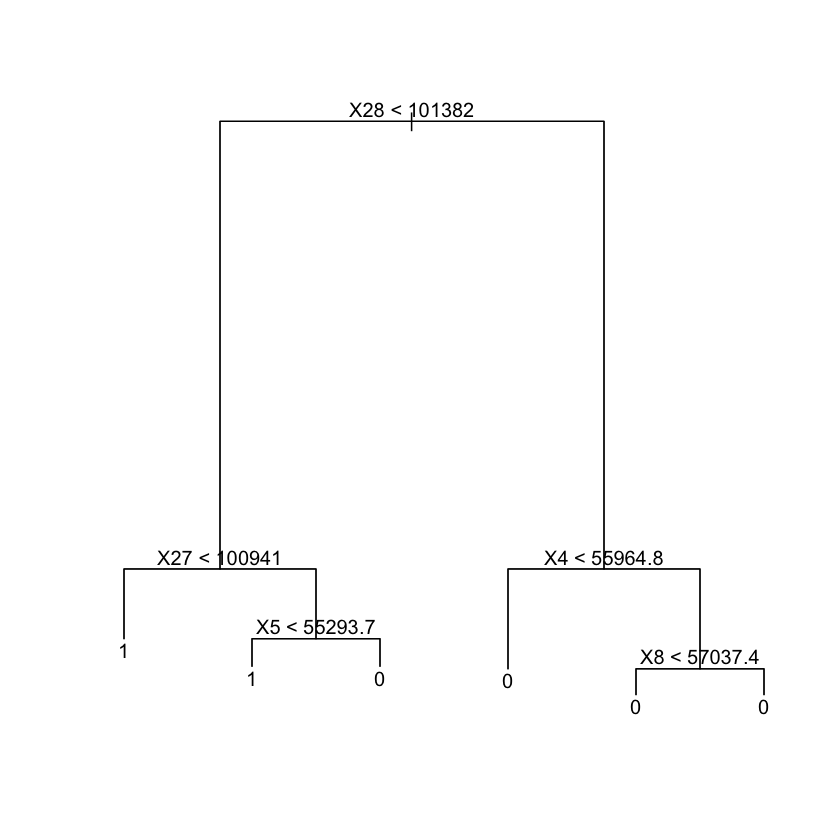

In [10]:
tree_binary_pruned <- prune.tree(binary_tree, best = 6)

# Summary of the tree
summary(tree_binary_pruned)

par(bg = "white")
plot(tree_binary_pruned); text(tree_binary_pruned, pretty = 0)

Using 6 nodes as the maximum depth, the most discriminating variables are:
- **X28**: This variable is used at the root node, indicating it has the highest importance in explaining the target variable among all predictors.
- **X27**: This variable refines the prediction on the left branch of the tree after the first split.
- **X4**: This variable refines the prediction on the right branch of the tree after the first split.

Utiliza este árbol óptimo para predecir en el test. Guarda las predicciones.


## <font color='magenta'> Predictions, occurrence

In [11]:
# Evaluate the tree on the test set
predictions_occurrence <- predict(tree_binary_pruned, newdata = test_data[,-1], type = "class")

# <font color="cyan"> Regression

Una vez obtenidas las predicciones de ocurrencia pasaremos a estimar la cantidad de precipitación. Primero creamos el dataset correspondiente.

A continuación construiremos dos árboles, uno entrenado sobre todo el conjunto de train y otro entrenado sólo sobre los días de lluvia (en el train). Empezamos por el primero de estos árboles. Construye el árbol completo ¿Cuántos nodos terminales obtienes? ¿Qué variables predictoras dan lugar a las primeras subdivisiones del árbol? ¿Son las mismas que para el caso de la ocurrencia?

## <font color='purple'> Full tree

### <font color="pink"> All data

In [12]:
# Create a regression dataset
regression_data <- data.frame(rain_amount = y_subset, x_subset)

# Split the data into train and test sets
train_regression <- regression_data[train_indices, ]
test_regression <- regression_data[-train_indices, ]


Regression tree:
tree(formula = rain_amount ~ ., data = train_regression, mincut = 1, 
    minsize = 2, mindev = 0)
Number of terminal nodes:  922 
Residual mean deviance:  0.003576 = 10.11 / 2828 
Distribution of residuals:
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.2667000 -0.0043480 -0.0003425  0.0000000  0.0000000  0.2973000 

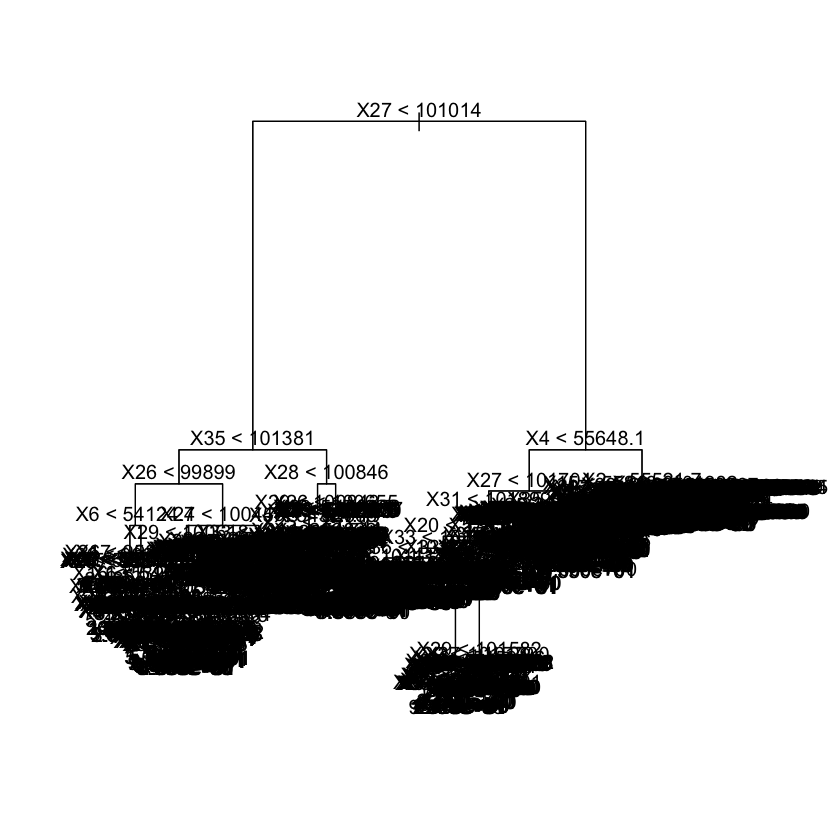

In [13]:
# Build the regression tree on the full training set
tree_full <- tree(rain_amount ~ ., data = train_regression, mincut = 1, minsize = 2, mindev = 0)

# Summary of the tree
summary(tree_full)

# Plot the tree
par(bg = "white")
plot(tree_full)
text(tree_full, pretty = 0)

The number of terminal nodes obtained with the full tree is 922.

- **X27**: This variable is used at the root node, providing the most significant split in the tree.
- **X35**: This variable refines predictions on the left branch of the tree after the first split.
- **X4**: This variable refines predictions on the right branch of the tree after the first split.

The variables are not exactly the same between the two cases (occurence and quantity).

- In the previous case, the root node was **X28**, while in this analysis, the root node is **X27**.
- For the left branch after the root split: previously, the split was based on **X27**. Now, the split is based on **X35**.
- For the right branch after the root split: the split remains the same, based on **X4** in both cases.

This shift suggests that **X27** and **X4** are consistently important variables across both models. However, the change in the root node (from **X28** to **X27**) and the second-level split on the left branch (from **X27** to **X35**) may indicate that the model’s focus or the distribution of the data led to differences in the tree structure and variable importance.

Al igual que hicimos para el caso de la ocurrencia, tendremos que podar este árbol tan complejo. Utiliza una cross-validación con un 10-fold para encontrar el número de nodos terminales del árbol óptimo. ¿Cuál es este número? ¿Qué predictores aparecen como los más importantes?

## <font color='purple'> Pruned tree

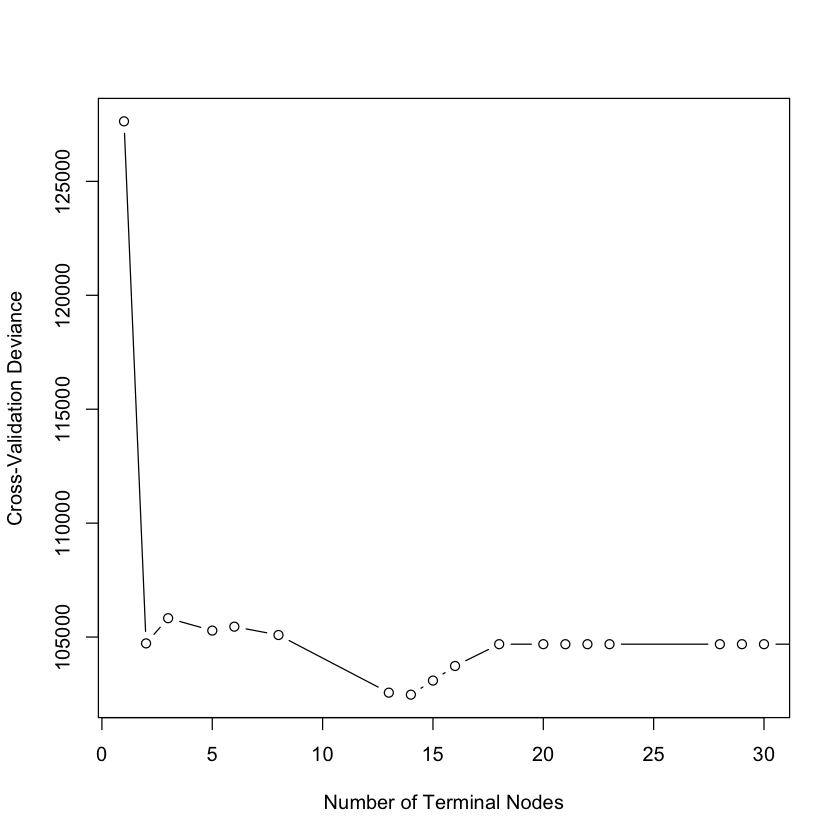

In [14]:
set.seed(123)
tree_full_cv <- cv.tree(tree_full, K = 10)

par(bg = "white")
plot(tree_full_cv$size, tree_full_cv$dev,
     type = "b", 
     xlim = c(1, 30), 
     xlab = "Number of Terminal Nodes", 
     ylab = "Cross-Validation Deviance"
)

The optimal number of terminal nodes is 14, as the deviance reaches its minimum at this point. After 14 nodes, the deviance starts to increase slightly, indicating that further splits may lead to overfitting rather than improving model performance.


Regression tree:
snip.tree(tree = tree_full, nodes = c(16L, 7L, 11L, 195L, 19L, 
96L, 13L, 36L, 25L, 10L, 37L, 17L))
Variables actually used in tree construction:
 [1] "X27" "X35" "X26" "X6"  "X29" "X28" "X4"  "X31" "X20" "X33"
Number of terminal nodes:  14 
Residual mean deviance:  18.05 = 67440 / 3736 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-21.2100  -0.9097  -0.3221   0.0000  -0.3221  45.9200 

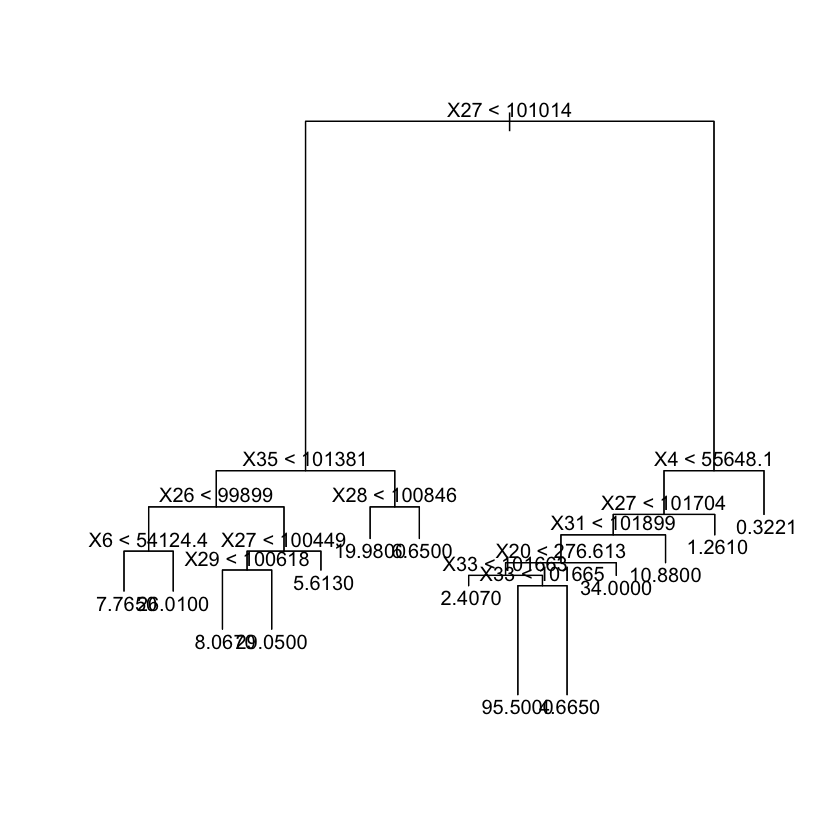

In [15]:
tree_full_pruned <- prune.tree(tree_full, best = 14)

# Summary of the tree
summary(tree_full_pruned)

par(bg = "white")
plot(tree_full_pruned); text(tree_full_pruned, pretty = 0)

Using 14 nodes, the most discriminating variables are:
- **X27**: This variable is used at the root node.
- **X35**: This variable refines predictions on the left branch of the tree after the first split.
- **X4**: This variable refines predictions on the right branch of the tree after the first split.

Utiliza el árbol óptimo que acabas de encontrar para predecir en el test, y conserva la predicción obtenida.

## <font color="magenta"> Predictions, quantity - All

In [16]:
# Prediction with Full Tree
predictions_full <- predict(tree_full_pruned, newdata = test_regression[,-1])

In [17]:
# Complete series
predictions_occurrence <- as.numeric(as.character(predictions_occurrence))
final_predictions_full <- predictions_occurrence * predictions_full

Repite el mismo proceso para el segundo árbol de regresión (el que sólo se entrena sobre los días de lluvia en el train).

Obtén las dos series predichas completas para el test (la secuencia lluvia/no lluvia será la misma en las dos) y valida tus resultados en función de las siguiente métricas:

Para la parte binaria lluvia/no lluvia: Accuracy.
Para la serie completa: RMSE, correlación de Spearman y ratio de varianzas.
Pregunta: ¿Cuál de los dos árboles da mejores resultados? ¿Por qué?

### <font color="pink"> Rain data


Regression tree:
tree(formula = rain_amount ~ ., data = rainy_days, mincut = 1, 
    minsize = 2, mindev = 0)
Number of terminal nodes:  604 
Residual mean deviance:  0.01516 = 2.319 / 153 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.200   0.000   0.000   0.000   0.000   0.225 

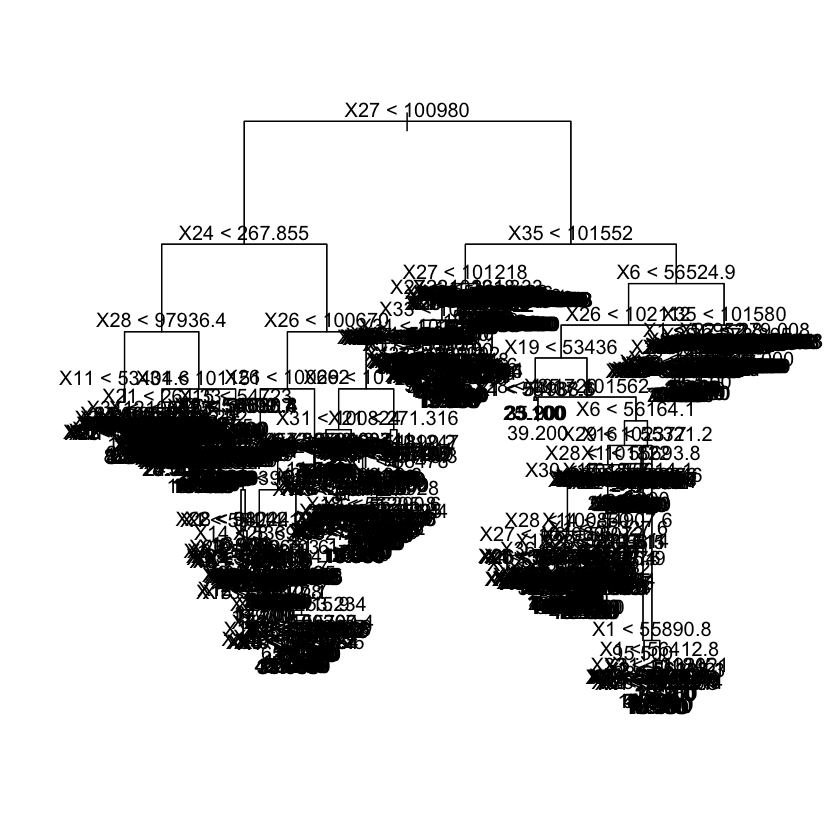

In [18]:
# Subset the training data to include only rainy days
rainy_days <- train_regression[train_regression$rain_amount >= 1, ]

# Build the regression tree for rainy days only
tree_rainy <- tree(rain_amount ~ ., data = rainy_days, mincut = 1, minsize = 2, mindev = 0)

# Summary of the tree
summary(tree_rainy)

# Plot the tree
par(bg = "white")
plot(tree_rainy)
text(tree_rainy, pretty = 0)

The number of terminal nodes obtained with the full tree is 604.

- **X27**: This variable is used at the root node.
- **X24**: This variable refines predictions on the left branch of the tree after the first split.
- **X35**: This variable refines predictions on the right branch of the tree after the first split.

Comparison:

1.	Occurrence Tree (**X28**, **X27**, **X4**): the root node differs, as **X28** was the most important variable in the occurrence tree, whereas **X27** takes this role in the rainy data tree. For the left branch **X27** appears as the splitting variable in the occurrence tree, while **X24** takes its place in the rainy data tree. For the right branch **X4** was used in the occurrence tree, whereas **X35** is now used in the rainy data tree.
2.	All Data Tree (**X27**, **X35**, **X4**): the root node is the same (**X27**) in both the rainy data and all data trees, indicating that X27 is consistently important in both models. For the left branch **X35** appears in the all data tree, while **X24** is used in the rainy data tree, suggesting a shift in the importance of predictors under rainy conditions. For the right branch: **X4** is replaced by **X35** in the rainy data tree, which might highlight changes in variable importance when focusing on rainy conditions.

Observations:

- **X27** emerges as a stable predictor, serving as the root node in both the all data and rainy data trees, but not in the occurrence tree.
- The shift in predictors for the left and right branches in the rainy data tree indicates that weather conditions might alter the relationships between predictors and the target variable.
- **X4**, which appeared consistently in the previous cases, is absent from the rainy data tree, replaced by **X35**, highlighting a significant contextual change.

## <font color='purple'> Pruned tree

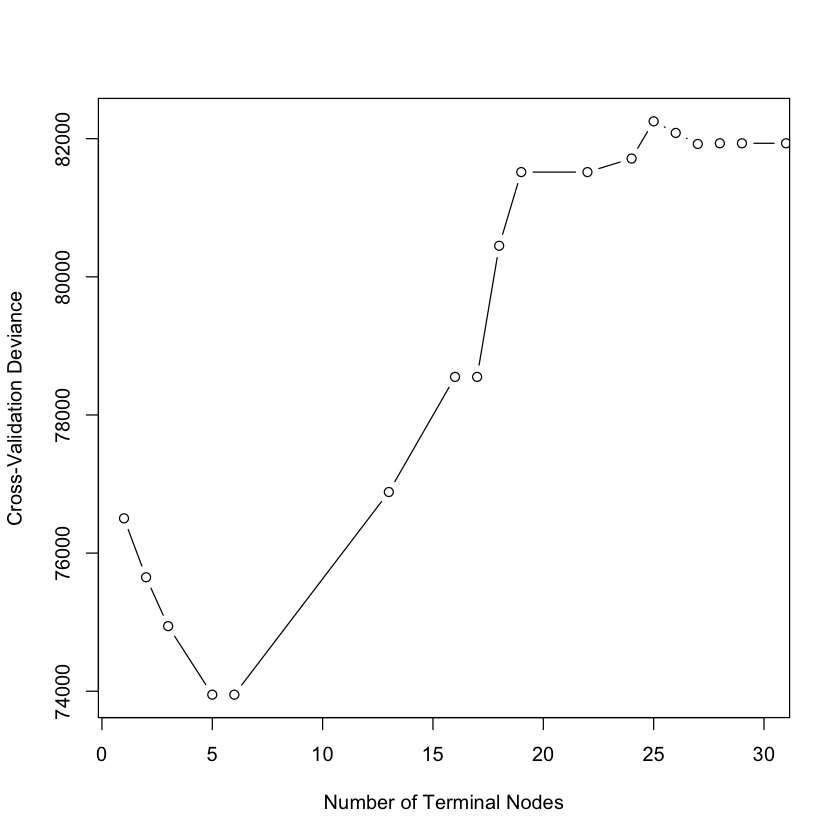

In [19]:
set.seed(123)
tree_rainy_cv <- cv.tree(tree_rainy, K = 10)

par(bg = "white")
plot(tree_rainy_cv$size, tree_rainy_cv$dev,
     type = "b", 
     xlim = c(1, 30), 
     xlab = "Number of Terminal Nodes", 
     ylab = "Cross-Validation Deviance"
)

The optimal number of terminal nodes is 6, as the plot shows that the cross-validation deviance is minimized at this point. Beyond 6, the deviance increases, suggesting overfitting or a lack of improvement in model performance.

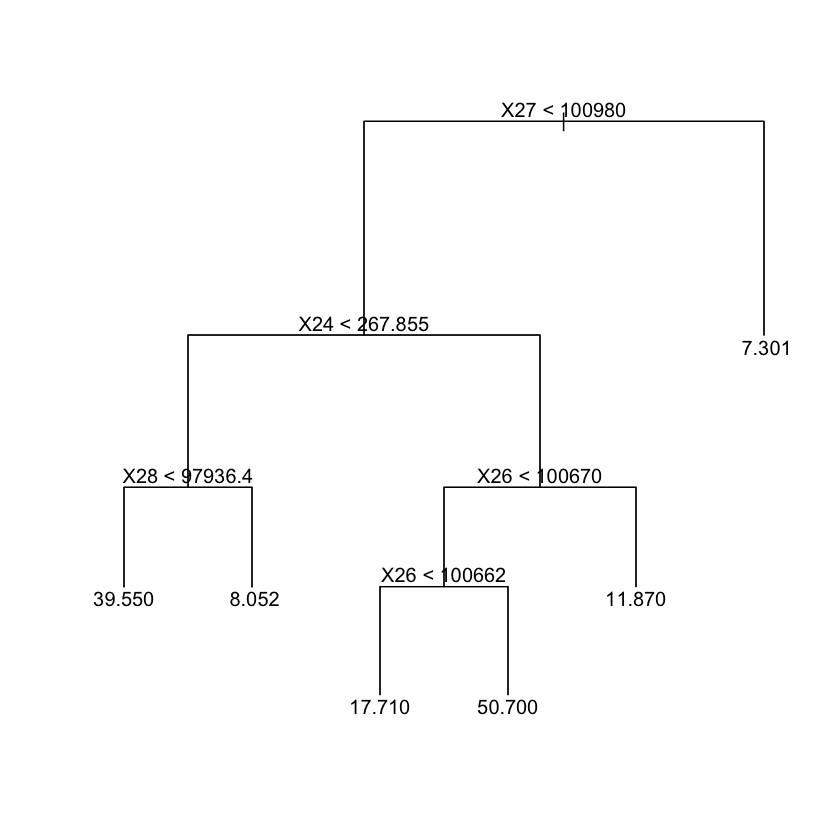

In [20]:
tree_rainy_pruned <- prune.tree(tree_rainy, best = 6)

par(bg = "white")
plot(tree_rainy_pruned); text(tree_rainy_pruned, pretty = 0)

Using 6 nodes:
- the root node remains **X27**, confirming its importance in explaining the target variable.
- the first split on the left branch is based on **X24**, consistent with the structure of the full tree.
- However, the right split observed in the full tree (**X35**) is no longer present in this pruned tree. This suggests that, when limiting the tree to 6 nodes, the additional complexity provided by splitting on **X35** does not significantly improve the model’s performance or predictive power. The absence of this split indicates a simplified decision-making process, where the focus shifts to the primary splits on **X27** and **X24**, reducing potential overfitting while still capturing the most critical patterns in the data.

## <font color="magenta"> Predictions, quantity - Rainy

In [21]:
# Prediction with Rainy Days Tree
predictions_rainy <- predict(tree_rainy_pruned, newdata = test_regression[,-1])

In [22]:
# Complete series
final_predictions_rainy <- predictions_occurrence * predictions_rainy

# <font color="cyan"> Results validation

In [23]:
# Accuracy
test_binary <- as.numeric(as.character(test_data$rain))

# Create the confusion matrix and extract accuracy
conf_matrix_binary <- confusionMatrix(factor(predictions_occurrence), factor(test_binary))

accuracy <- conf_matrix_binary$overall["Accuracy"]
# print(conf_matrix_binary)

In [24]:
# RMSE
rmse_full <- sqrt(mean((test_regression$rain_amount - final_predictions_full)^2))
rmse_rainy <- sqrt(mean((test_regression$rain_amount - final_predictions_rainy)^2))

# Spearman Correlation
spearman_full <- cor(test_regression$rain_amount, final_predictions_full, method = "spearman")
spearman_rainy <- cor(test_regression$rain_amount, final_predictions_rainy, method = "spearman")

# Variance Ratio
variance_ratio_full <- var(final_predictions_full) / var(test_regression$rain_amount)
variance_ratio_rainy <- var(final_predictions_rainy) / var(test_regression$rain_amount)

In [25]:
cat("Individual Tree - Binary Model:\n")
cat("Accuracy:", accuracy, "\n\n")

cat("Individual Tree - Full Model:\n")
cat("RMSE:", rmse_full, "\n")
cat("Spearman Correlation:", spearman_full, "\n")
cat("Variance Ratio:", variance_ratio_full, "\n\n")

cat("Individual Tree - Rainy Days Model:\n")
cat("RMSE:", rmse_rainy, "\n")
cat("Spearman Correlation:", spearman_rainy, "\n")
cat("Variance Ratio:", variance_ratio_rainy, "\n")

Individual Tree - Binary Model:
Accuracy: 0.8408 

Individual Tree - Full Model:
RMSE: 4.95481 


Spearman Correlation: 0.5513282 
Variance Ratio: 0.561241 

Individual Tree - Rainy Days Model:
RMSE: 4.678009 
Spearman Correlation: 0.5511415 
Variance Ratio: 0.6184947 


| Metric                | Full Tree        | Rainy Days Tree   | Binary Tree |
|-----------------------|------------------|-------------------|-------------|
| RMSE                  | 4.955            | 4.678             |             |
| Spearman Correlation  | 0.551            | 0.551             |             |
| Variance Ratio        | 0.561            | 0.618             |             |
| Accuracy (%)          |                  |                   | 84.08       |

The binary tree achieves a good accuracy of 84.08%, demonstrating its effectiveness in classification tasks.

The same Spearman correlation value (0.551) for both the full tree and the rainy days tree reflects that the predictors were likely pre-selected using a method based on Spearman correlation, ensuring their relevance for explaining the target variable. This also suggests that the initial selection of predictors maintained consistency and coherence across the models.

The RMSE for the rainy days model (4.678) is lower than that of the full tree (4.955), indicating that it better captures the trend of the observed data and provides more accurate predictions. 5.59% of improvement.

The variance ratio for the rainy days tree (0.618) is higher and closer to 1 compared to the full tree (0.561). This indicates that the rainy days model explains a greater proportion of the variation in the target variable, making it a more reliable model. 10.16% of improvement.

**Which model ?**

Based on these results, I would choose the rainy days model, as it outperforms the full tree in terms of RMSE and variance ratio, indicating better predictive accuracy and explanatory power.

# <font color="red"> -------------------------------------------------------------------

## Random forests (2.5 puntos)

A continuación vamos a realizar el mismo ejercicio pero sustituyendo árboles individuales por random forests, empleando para ello en este ejercicio la técnica de “bagging”. Empecemos con el evento ocurrencia. Para estimar cuál sería el tamaño óptimo de nuestro random forest, prueba bosques de hasta 1000 árboles (utiliza la función randomForest) y plotea los errores “Out-Of-Bag” (OOB). ¿Con cuántos árboles te quedarías?

***Nota:*** Hemos visto en la teoría que además del número de árboles, el otro parámetro a ajustar en los random forests es el número de predictores que se consideran en cada nodo para el splitting. En este ejemplo utlizaremos los valores típicos; n−−√ en problemas de clasificación y n/3 en problemas de predicción (siendo n el número total de predictores disponibles).

In [27]:
library(randomForest)

# <font color="cyan"> Classification

## <font color="purple"> Full RF

In [28]:
set.seed(123)

# Bagging
mtry_classification <- floor(sqrt(ncol(train_data) - 1))

# Random forest
rf_model <- randomForest(
  rain ~ ., 
  data = train_data, 
  ntree = 1000,
  mtry = mtry_classification,
)

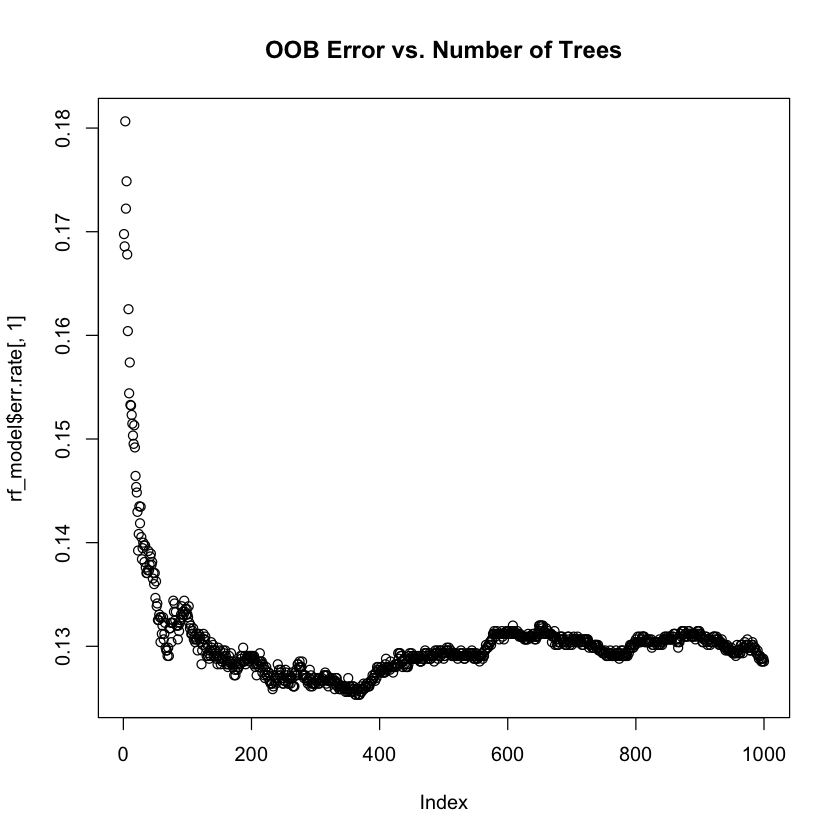

In [29]:
# Plot OOB errors
par(bg = "white")
plot(rf_model$err.rate[, 1], main = "OOB Error vs. Number of Trees")

## <font color="purple"> Filtered RF

In [30]:
oob_errors <- rf_model$err.rate[, "OOB"]
optimal_trees <- which.min(oob_errors)
cat("Optimal number of trees:", optimal_trees, "\n")

Optimal number of trees: 362 


The resulting optimal number of trees is 362, as this is the point where the error rate reaches its minimum.

In [31]:
# Model with optimal number of trees
rf_model_optimal <- randomForest(
  rain ~ ., 
  data = train_data, 
  ntree = optimal_trees,
  mtry = mtry_classification,
)

print(rf_model_optimal)


Call:
 randomForest(formula = rain ~ ., data = train_data, ntree = optimal_trees,      mtry = mtry_classification, ) 
               Type of random forest: classification
                     Number of trees: 362
No. of variables tried at each split: 6

        OOB estimate of  error rate: 13.09%
Confusion matrix:
     0   1 class.error
0 2826 167  0.05579686
1  324 433  0.42800528


Utiliza el bosque de tamaño óptimo parar predecir la ocurrencia en el test, y conserva la predicción.

## <font color="magenta"> Predictions, occurence

In [32]:
predictions_occurrence_rf <- predict(rf_model_optimal, newdata = test_data[, -1])

# <font color="cyan"> Regression

Seguidamente, tal y como hicimos con los árboles individuales, vamos a crear dos random forests para la cantidad, uno que se entrene sobre todo el dataset de train y otro que se entrene sólo sobre los días de lluvia (en el train). De nuevo, tendrás que estimar cuál es el número óptimo de árboles en cada uno de ellos (prueba bosques de hasta 1000 árboles). ¿Qué tamaños óptimos obtienes?

## <font color="purple"> Full RF

### <font color="pink"> All data

In [33]:
mtry_regression <- floor(ncol(train_regression) / 3)

# Random forest
set.seed(123)
rf_full <- randomForest(
  rain_amount ~ .,
  data = train_regression,
  ntree = 1000,
  mtry = mtry_regression,
)

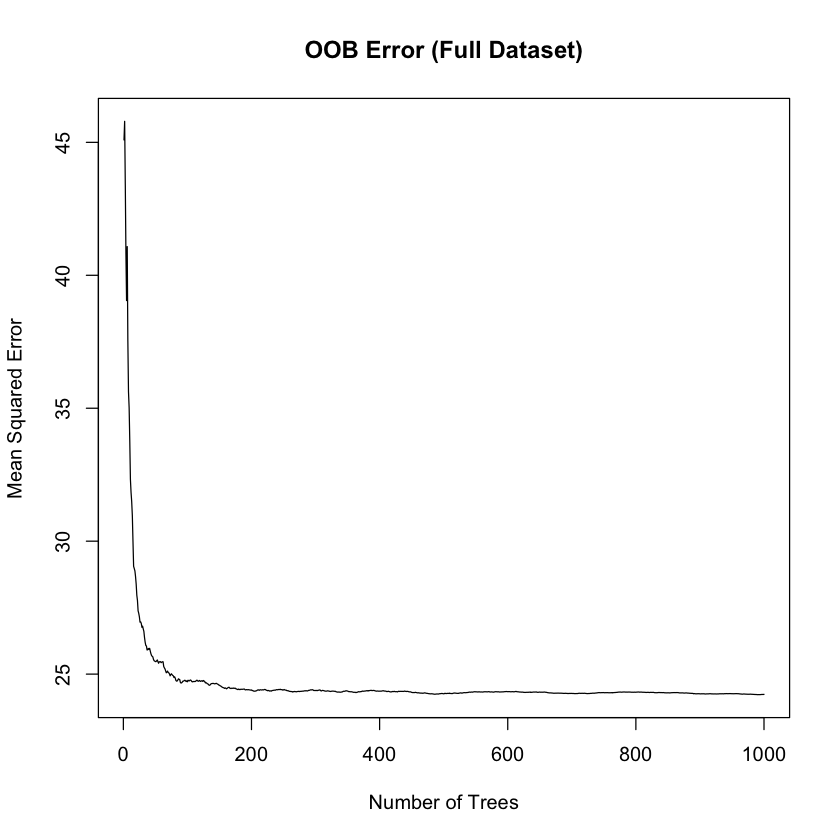

In [34]:
# Plot OOB errors
par(bg = "white")
plot(rf_full$mse, type = "l", xlab = "Number of Trees", ylab = "Mean Squared Error",
     main = "OOB Error (Full Dataset)")

In [35]:
optimal_trees_full <- which.min(rf_full$mse)
cat("Optimal number of trees (Full Dataset):", optimal_trees_full, "\n")

Optimal number of trees (Full Dataset): 990 


In [36]:
threshold <- 0.001
min_trees <- 100

oob_differences <- abs(diff(rf_full$mse))
optimal_trees_full <- which(oob_differences < threshold & seq_along(oob_differences) >= min_trees)[1]

if (!is.na(optimal_trees_full)) {
  cat("Optimal number of trees (with threshold, starting at", min_trees, "):", optimal_trees_full, "\n")
} else {
  cat("No optimal value found within threshold, defaulting to maximum trees:", 1000, "\n")
}

Optimal number of trees (with threshold, starting at 100 ): 120 


The optimal number of trees for the full dataset, based on the minimum MSE, is very close to the maximum number of trees. However, as the plot shows, the RMSE improvement beyond a certain point is minimal. Therefore, I set a threshold to select a more practical optimal value, resulting in 120 trees.

## <font color="purple"> Filtered RF

In [37]:
set.seed(123)
rf_full_optimal <- randomForest(
  rain_amount ~ ., 
  data = train_regression, 
  ntree = optimal_trees_full,
  mtry = mtry_regression,
)

## <font color="purple"> Full RF

### <font color="pink"> Rain data

In [38]:
rainy_train <- train_regression[train_regression$rain_amount >= 1, ]

# Random forest
set.seed(123)
rf_rainy <- randomForest(
  rain_amount ~ .,
  data = rainy_train,
  ntree = 1000,
  mtry = mtry_regression,
)

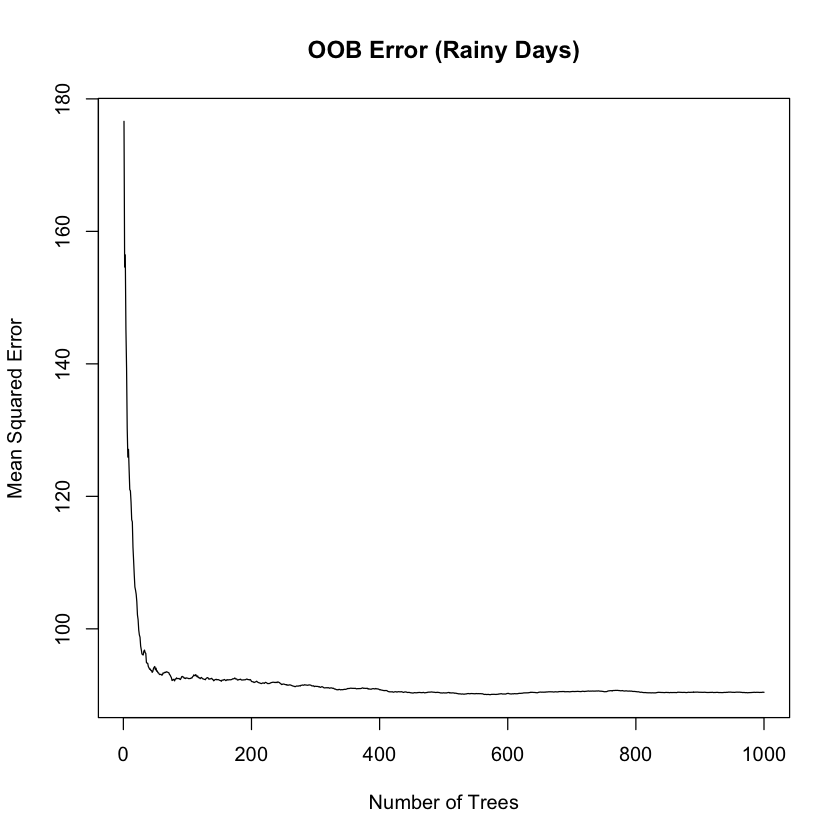

In [39]:
# Plot OOB errors
par(bg = "white")
plot(rf_rainy$mse, type = "l", xlab = "Number of Trees", ylab = "Mean Squared Error",
     main = "OOB Error (Rainy Days)")

In [40]:
optimal_trees_rainy <- which.min(rf_rainy$mse)
cat("Optimal number of trees (Rainy Days):", optimal_trees_rainy, "\n")

Optimal number of trees (Rainy Days): 573 


In [41]:
threshold <- 0.001
min_trees <- 100

oob_differences <- abs(diff(rf_rainy$mse))
optimal_trees_rainy <- which(oob_differences < threshold & seq_along(oob_differences) >= min_trees)[1]

if (!is.na(optimal_trees_rainy)) {
  cat("Optimal number of trees (with threshold, starting at", min_trees, "):", optimal_trees_rainy, "\n")
} else {
  cat("No optimal value found within threshold, defaulting to maximum trees:", 1000, "\n")
}

Optimal number of trees (with threshold, starting at 100 ): 188 


As in the previous case, I determine the optimal number of trees using the same threshold. This resulted in selecting 188 trees as the optimal value for this case.

## <font color="purple"> Filtered RF

In [42]:
set.seed(123)
rf_rainy_optimal <- randomForest(
  rain_amount ~ ., 
  data = rainy_train, 
  ntree = optimal_trees_rainy,
  mtry = mtry_regression,
)

Utiliza los bosques óptimos encontrados para predecir la cantidad en el test, y conserva las predicciones obtenidas.

Construye las predicciones completas (ocurrencia×cantidad) de test y valídalas en función de las mismas métricas utilizadas en el apartado anterior.

Pregunta: Compara estos resultados con los obtenidos para árboles individuales. ¿Qué conclusiones obtienes de la comparación entre árboles individuales y random forests?

## <font color="magenta"> Predictions, quantity

In [43]:
# Prediction with Full Random Forest
predictions_full_rf <- predict(rf_full_optimal, newdata = test_regression[,-1])

In [44]:
# Prediction with Rainy Days Tree
# Predict precipitation amounts on the rainy days in the test set
predictions_rainy_rf <- predict(rf_rainy_optimal, newdata = test_regression[,-1])

In [45]:
# Complete series
predictions_occurrence_rf <- as.numeric(as.character(predictions_occurrence_rf))
final_predictions_full_rf <- predictions_occurrence_rf * predictions_full_rf
final_predictions_rainy_rf <- predictions_occurrence_rf * predictions_rainy_rf

# <font color="cyan"> Results validation

In [46]:
conf_matrix_rf <- confusionMatrix(factor(predictions_occurrence_rf), factor(test_data$rain))

In [47]:
# RMSE
rmse_full_rf <- sqrt(mean((test_regression$rain_amount - final_predictions_full_rf)^2))
rmse_rainy_rf <- sqrt(mean((test_regression$rain_amount - final_predictions_rainy_rf)^2))

# Spearman Correlation
spearman_full_rf <- cor(test_regression$rain_amount, final_predictions_full_rf, method = "spearman")
spearman_rainy_rf <- cor(test_regression$rain_amount, final_predictions_rainy_rf, method = "spearman")

# Variance Ratio
variance_ratio_full_rf <- var(final_predictions_full_rf) / var(test_regression$rain_amount)
variance_ratio_rainy_rf <- var(final_predictions_rainy_rf) / var(test_regression$rain_amount)

In [48]:
cat("Random Forest - Binary Model:\n")
cat("Accuracy:", conf_matrix_rf$overall["Accuracy"], "\n\n")

cat("Random Forest - Full Model:\n")
cat("RMSE:", rmse_full_rf, "\n")
cat("Spearman Correlation:", spearman_full_rf, "\n")
cat("Variance Ratio:", variance_ratio_full_rf, "\n\n")

cat("Random Forest - Rainy Days Model:\n")
cat("RMSE:", rmse_rainy_rf, "\n")
cat("Spearman Correlation:", spearman_rainy_rf, "\n")
cat("Variance Ratio:", variance_ratio_rainy_rf, "\n")

Random Forest - Binary Model:
Accuracy: 0.8552 

Random Forest - Full Model:
RMSE: 4.583356 
Spearman Correlation: 0.553433 
Variance Ratio: 0.4538726 

Random Forest - Rainy Days Model:
RMSE: 4.740923 
Spearman Correlation: 0.5513918 
Variance Ratio: 0.6190948 


| Metric                | Full Random Forest  | Rainy Days Random Forest  | Binary Random Forest |
|-----------------------|---------------------|---------------------------|----------------------|
| RMSE                  | 4.583               | 4.741                     |                      |
| Spearman Correlation  | 0.553               | 0.551                     |                      |
| Variance Ratio        | 0.454               | 0.619                     |                      |
| Accuracy (%)          |                     |                           | 85.52                |

The accuracy of the Binary Random Forest model (85.52%) is good, indicating strong performance in classification tasks.

The RMSE for the Rainy Days model (4.741) is slightly higher than that of the Full Random Forest model (4.583), meaning slightly worse (3.45%). This suggests a small trade-off in predictive accuracy when focusing only on rainy days.

The Spearman correlation remains nearly the same between the Full Random Forest (0.553) and Rainy Days Random Forest (0.551), indicating, ones again, consistent relationships between the predictors and the target variable across the two models.

The variance ratio shows a significant improvement (36.34%) for the Rainy Days Random Forest model (0.619) compared to the Full Random Forest (0.454). This indicates that the Rainy Days model captures a larger proportion of the variation in the target variable, likely due to its focus on a more specific subset of data.

**Which model ?**

While the Full Random Forest model achieves a slightly lower RMSE, the Rainy Days Random Forest model demonstrates a significant improvement in the variance ratio. This indicates that the Rainy Days model offers better explanatory power for the target variable under rainy conditions. Therefore, even when using Random Forest, I would choose the Rainy Days model.

# <font color="cyan"> Comparison between Individual Tree Model and Random Forest Model </font>

| Metric       | Individual Tree | Random Forest |
|--------------|-----------------|---------------|
| Accuracy (%) | 84.08           | 85.52         |

The Random Forest model achieves a higher accuracy (85.52%) compared to the Individual Tree model (84.08%). This demonstrates that Random Forest improves classification performance by combining multiple trees and reducing variance.

| Metric                | Individual Tree - Full Model | Random Forest - Full Model |
|-----------------------|------------------------------|----------------------------|
| RMSE                  | 4.955                        | 4.594                      |
| Spearman Correlation  | 0.551                        | 0.553                      |
| Variance Ratio        | 0.561                        | 0.448                      |

The Random Forest model (4.594) has a lower RMSE than the Individual Tree model (4.955), showing an improvement of 7.29% in prediction accuracy.

The Spearman correletion still remains the same.

The Individual Tree model (0.561) performs better than the Random Forest model (0.448) in explaining the variance of the target variable. The Random Forest’s Variance Ratio is 20.14% worse than that of the Individual Tree, possibly due to overfitting in the latter.

| Metric                | Individual Tree - Rainy Days Model | Random Forest - Rainy Days Model |
|-----------------------|------------------------------------|----------------------------------|
| RMSE                  | 4.678                              | 4.741                            |
| Spearman Correlation  | 0.551                              | 0.551                            |
| Variance Ratio        | 0.618                              | 0.619                            |

The Random Forest Rainy Days Model has a higher RMSE (4.741) than the Individual Tree Rainy Days Model (4.678), showing a 1.35% worsening in prediction accuracy.

Both models show the same Spearman correlation (0.551), reflecting consistent predictor relationships with the target variable.

The Variance Ratio for the Random Forest Rainy Days Model (0.619) is slightly better than that of the Individual Tree Rainy Days Model (0.618), showing a 0.16%.

In summary, the Random Forest model generally outperforms the Individual Tree model in terms of accuracy and RMSE, demonstrating its ability to reduce variance and improve prediction accuracy through ensemble learning. However, the Individual Tree model shows a slightly better Variance Ratio, particularly in the full model, likely due to its tendency to overfit. For the Rainy Days models, the performance differences between the two approaches are minimal, with near-identical Spearman correlations and Variance Ratios, suggesting that both models handle this subset of data similarly. However, one should always keep in mind the inherent variability of Decision Trees. Overall, Random Forest proves to be the more robust and reliable choice for weather prediction tasks.

# <font color="red"> -------------------------------------------------------------------

## Modelos lineales generalizados (GLMs) (1.5 puntos)

Usaremos a continuación GLMs para el mismo problema abordado en los apartados anteriores. Como ya hemos visto en otras sesiones, debemos utilizar la familia binomial con función de enlace logit (regresión logística) para clasificación y la familia Gamma con función de enlace logarítmica para la cantidad.

Comenzamos con el modelo para la ocurrencia.

Una vez tenemos el modelo, lo utilizamos para predecir en el test. Tendremos que convertir la predicción probabilística obtenida en binaria (considera un umbral 0.5).

A continuación, ajustamos el modelo de cantidad. Para ello tenemos que seleccionar previamente los días de lluvia (la familia Gamma sólo acepta valores positivos).

Utilizamos el modelo obtenido para predecir la cantidad en el test.

De nuevo, multiplicamos la ocurrencia por la cantidad para obtener la predicción completa en el test y la validamos en función de las métricas de validación que utilizamos para CART y random forests.

Pregunta: Compara estos resultados con los obtenidos para CART y random forests. ¿Qué conclusiones obtienes?

# <font color="cyan"> Binomial

In [49]:
# Scale the predictors
x_scaled <- scale(x_subset)

# Division train/test
x_train <- x_scaled[train_indices, ]
x_test <- x_scaled[-train_indices, ]
y_train <- y_subset[train_indices]
y_test <- y_subset[-train_indices]

y_train_bin <- ifelse(y_train >= 1, 1, 0)
y_test_bin <- ifelse(y_test >= 1, 1, 0)

# Combine predictors and binary target into a dataframe
train_data_bin <- data.frame(rain = factor(y_train_bin), x_train)
test_data_bin <- data.frame(rain = factor(y_test_bin), x_test)

In [50]:
# Model for Occurrence (Binomial Logistic Regression)
set.seed(123)
glm_occurrence <- glm(rain ~ .,
    family = binomial(link = "logit"),
    data = train_data_bin
)

## <font color="magenta"> Predictions, occurence

In [51]:
predictions_occurrence_prob <- predict(glm_occurrence, newdata = test_data_bin[,-1], type = "response")
# Convert probabilities to binary predictions
predictions_occurrence_glm <- ifelse(predictions_occurrence_prob > 0.5, 1, 0)

In [58]:
library(pROC)

Setting levels: control = 0, case = 1



Setting direction: controls < cases



[1] "AUC: 0.898025171552354"


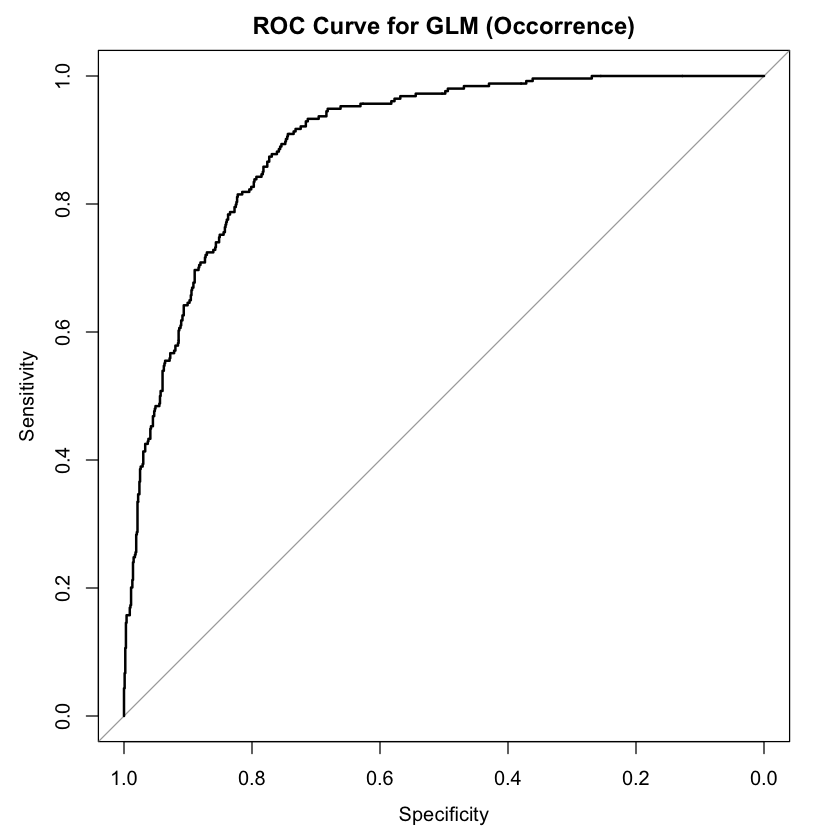

In [53]:
roc_curve <- roc(test_data_bin$rain, predictions_occurrence_prob)

# Plot della curva ROC
par(bg = "white")
plot(roc_curve, main = "ROC Curve for GLM (Occorrence)")
auc_value <- auc(roc_curve)
print(paste("AUC:", auc_value))

Although the ROC curve for the GLM model was not explicitly required, it serves as an excellent method to verify the model’s ability to distinguish between classes.

The curve shows excellent performance, with a steep rise near the top-left corner, indicating high sensitivity and specificity. This suggests that the model effectively distinguishes between classes across various thresholds.

# <font color="cyan"> Gamma

In [54]:
# Combine predictors and binary target into a dataframe
train_data_reg <- data.frame(rain_amount = y_train, x_train)
test_data_reg <- data.frame(rain_amount = y_test, x_test)

In [55]:
rainy_train <- train_data_reg[train_data_reg$rain_amount >= 1, ]  # Filter rainy days

# Model for Quantity (Gamma Regression)
set.seed(123)
glm_quantity <- glm(
  rain_amount ~ .,
  family = Gamma(link = "log"),
  data = rainy_train
)

## <font color="magenta"> Predictions, quantity

In [56]:
predictions_occurrence_glm <- factor(predictions_occurrence_glm, levels = levels(test_data_bin$rain))

# Calculate accuracy
conf_matrix_glm <- confusionMatrix(
  predictions_occurrence_glm, 
  test_data_bin$rain
)

accuracy_glm <- conf_matrix_glm$overall["Accuracy"]
cat("Accuracy (GLM Binary Model):", accuracy_glm, "\n")

Accuracy (GLM Binary Model): 0.852 


In [57]:
# Predict quantities on rainy days in the test set
set.seed(123)
predictions_quantity_glm <- predict(
  glm_quantity,
  newdata = test_data_reg[,-1],
  type = "response"
)

predictions_occurrence_glm <- as.numeric(as.character(predictions_occurrence_glm))

final_predictions_glm <- predictions_occurrence_glm * predictions_quantity_glm

# <font color="cyan"> Results validation

In [59]:
# Metrics for GLM
rmse_glm <- sqrt(mean((test_data_reg$rain_amount - final_predictions_glm)^2))
spearman_glm <- cor(test_data_reg$rain_amount, final_predictions_glm, method = "spearman")
variance_ratio_glm <- var(final_predictions_glm) / var(test_data_reg$rain_amount)

In [60]:
# Print metrics for GLM
cat("GLM Model, Binomial:\n")
cat("Accuracy:", accuracy_glm, "\n\n")
cat("GLM Model, Gamma:\n")
cat("RMSE:", rmse_glm, "\n")
cat("Spearman Correlation:", spearman_glm, "\n")
cat("Variance Ratio:", variance_ratio_glm, "\n")

GLM Model, Binomial:
Accuracy: 0.852 

GLM Model, Gamma:
RMSE: 4.633044 
Spearman Correlation: 0.531818 
Variance Ratio: 0.7610113 


# <font color="cyan"> Comparison among Individual Tree, Random Forest and GLM

| Metric       | Individual Tree | Random Forest |  GLM  |
|--------------|-----------------|---------------| ----- |
| Accuracy (%) | 84.08           | 85.52         | 85.20 |

GLM reaches an accuracy of 85.20%, slightly lower than the Random Forest but still higher than the Individual Tree accuracy. This demonstrates that the GLM, despite being a simpler and more interpretable model, performs almost as well as the Random Forest.

| Metric                | Individual Tree - Full Model | Random Forest - Full Model |  GLM  |
|-----------------------|------------------------------|----------------------------| ----- |
| RMSE                  | 4.955                        | 4.594                      | 4.633 |
| Spearman Correlation  | 0.551                        | 0.553                      | 0.532 |
| Variance Ratio        | 0.561                        | 0.448                      | 0.761 |

The Spearman correlation shows negligible variation across models.

However, with a lower RMSE (4.633 vs. 4.955) and a significantly higher Variance Ratio (0.761 vs. 0.561), the GLM clearly outperforms the Individual Tree model.

Compared to Random Forest, GLM has a slightly higher RMSE (4.633 vs. 4.594), indicating a minor loss in accuracy. However, GLM demonstrates a significant improvement in Variance Ratio (69.87%), showing that it better represents the variability of the test data. Based on these results, GLM could be considered the best model overall due to its simplicity and robust performance.

| Metric                | Individual Tree - Rainy Days Model | Random Forest - Rainy Days Model |  GLM  |
|-----------------------|------------------------------------|----------------------------------| ----- |
| RMSE                  | 4.678                              | 4.741                            | 4.633 |
| Spearman Correlation  | 0.551                              | 0.551                            | 0.532 |
| Variance Ratio        | 0.618                              | 0.619                            | 0.761 |

Compared to the Rainy Days models based on both Individual Tree and Random Forest, GLM demonstrates significant improvements by achieving a lower RMSE and a substantially higher Variance Ratio, indicating better predictive accuracy and a more realistic representation of data variability. Also in this case GLM results the best model overall.

## k nearest neighbors (k-NN) (1.5 puntos)

La última de las técnicas a utilizar será vecinos cercanos (ten en cuenta que en este caso ya no tendremos que predecir por separado ocurrencia y cantidad). Comenzaremos por una versión de k-NN en la que sólo se considere el vecino más cercano (utiliza la función knn.reg del paquete FNN).

Nota: Recuerda que en la técnica k-NN es muy importante pre-procesar adecuadamente (estandarizar) los predictores.

Como vimos en su día, el único parámetro a ajustar en la técnica k-NN es k (número de vecinos). Utilizaremos el paquete caret para encontrar el k óptimo en nuestro problema. Para ello, considera una cross-validación con 10 folds sobre el dataset de train y barre todos los k impares desde 1 a 50.

Utiliza este k óptimo para predecir en el test.

Valida las dos predicciones (con k=1 y con k=óptimo) en el test, en función de las medidas que se han ido utilizando en los apartados anteriores.

Pregunta: ¿Qué diferencias obtienes entre las dos versiones utilizadas de la técnica k-NN? ¿A qué se deben?

In [61]:
library(FNN)

In [62]:
# Normalized predictors
train_data <- data.frame(rain_amount = y_train, x_train)
test_data <- data.frame(rain_amount = y_test, x_test)

## <font color="magenta"> K = 1

In [63]:
# k-NN with k = 1
knn_k1 <- knn.reg(
    train = x_train,
    test = x_test,
    y = y_train,
    k = 1
)

# Predictions with k = 1
predictions_k1 <- knn_k1$pred

## <font color="magenta"> K = optimal

Optimal k: 39 


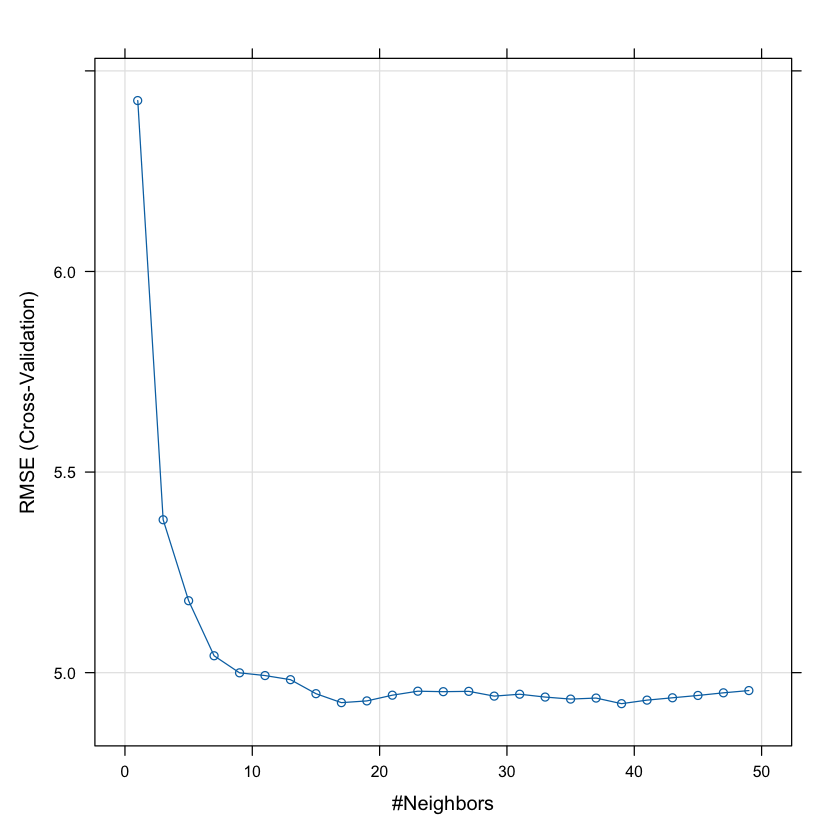

In [64]:
# Cross-validation setup
set.seed(123)
cv_control <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation
grid <- expand.grid(k = seq(1, 50, by = 2))

# Train KNN model with Cross-Validation
knn_cv <- train(
  rain_amount ~ .,
  data = train_data,
  method = "knn",
  tuneGrid = grid,
  trControl = cv_control
)

# Optimal k
optimal_k <- knn_cv$bestTune$k
cat("Optimal k:", optimal_k, "\n")
plot(knn_cv)

Although the optimal k identified by cross-validation is 39,  **k = 19**  is a reasonable choice as the RMSE stabilizes after  k = 19. Using  k = 19  strikes a balance between model simplicity and performance while avoiding over-smoothing that may occur with larger k.

In [65]:
optimal_k = 19

# Predictions with optimal k
predictions_knn <- knn.reg(
  train = x_train,
  test = x_test,
  y = y_train,
  k = optimal_k
)

predictions_knn <- predictions_knn$pred

# <font color='cyan'> Results validation

In [66]:
# Accuracy
predictions_k1_bin <- ifelse(predictions_k1 >= 1, 1, 0)
rain_bin <- ifelse(test_data$rain_amount >= 1, 1, 0)
predictions_knn_bin <- ifelse(predictions_knn >= 1, 1, 0)

conf_matrix_knn_k1 <- confusionMatrix(factor(predictions_k1_bin), factor(rain_bin))
conf_matrix_knn_kopt <- confusionMatrix(factor(predictions_knn_bin), factor(rain_bin))
accuracy_knn_k1 <- conf_matrix_knn_k1$overall["Accuracy"]
accuracy_knn_kopt <- conf_matrix_knn_kopt$overall["Accuracy"]

In [67]:
# Metrics
rmse_k1 <- sqrt(mean((y_test - predictions_k1)^2))
spearman_k1 <- cor(y_test, predictions_k1, method = "spearman")
variance_ratio_k1 <- var(predictions_k1) / var(y_test)

# Stampa dei risultati
cat("Metrics for k-NN (k=1):\n")
cat("Accuracy:", accuracy_knn_k1, "\n")
cat("RMSE:", rmse_k1, "\n")
cat("Spearman Correlation:", spearman_k1, "\n")
cat("Variance Ratio:", variance_ratio_k1, "\n")

Metrics for k-NN (k=1):
Accuracy: 0.828 


RMSE: 5.464109 
Spearman Correlation: 0.5268802 
Variance Ratio: 1.063064 


In [68]:
# Metrics
rmse <- sqrt(mean((test_data$rain_amount - predictions_knn)^2))
spearman <- cor(test_data$rain_amount, predictions_knn, method = "spearman")
variance_ratio <- var(predictions_knn) / var(test_data$rain_amount)

cat("Metrics for k-NN (k=19):\n")
cat("Accuracy:", accuracy_knn_kopt, "\n")
cat("RMSE:", rmse, "\n")
cat("Spearman Correlation:", spearman, "\n")
cat("Variance Ratio:", variance_ratio, "\n")

Metrics for k-NN (k=19):
Accuracy: 0.7808 
RMSE: 4.441745 
Spearman Correlation: 0.5981112 
Variance Ratio: 0.30704 


| Metric                | k-NN (k=1) | k-NN (k=19) |
|-----------------------|------------|-------------|
| RMSE                  | 5.464      | 4.442       |
| Spearman Correlation  | 0.527      | 0.598       |
| Variance Ratio        | 1.063      | 0.307       |
| Accuracy (%)          | 82.80      | 78.08       |

**RMSE**
   - **k=1:** The RMSE is higher (5.464), indicating poorer model performance.
   - **k=19:** The RMSE is significantly lower (4.422), suggesting better predictive accuracy.

With k=1, the model is highly sensitive to noise as it relies on a single neighbor for predictions. In contrast, k=19 averages more neighbors, smoothing predictions and reducing errors.

**Spearman Correlation:**
   - **k=1:** The correlation is lower (0.527), indicating that the model poorly captures the monotonic relationship between variables.
   - **k=19:** The correlation slightly improves (0.598), showing that the model ranks predictions a bit more consistently with the true values.

A higher k increases prediction stability by reducing the influence of extreme values.

**Variance Ratio:**
   - **k=1:** The variance ratio is higher (1.063), indicating the model overestimates variance in predictions.
   - **k=19:** The variance ratio significantly decreases (0.307), suggesting the model better captures the variability in the test data.

With k=1, the model is more volatile and prone to overfitting, while k=19 averages neighbors to reduce extreme predictions.

**Accuracy (%):**
   - **k=1:** Accuracy is higher (82.80%).
   - **k=19:** Accuracy slightly decreases (78.08%).

While k=1 achieves better classification accuracy, this metric does not reflect overall prediction quality. k=19 sacrifices some accuracy to achieve better generalization.

---

These differences primarily depend on the nature of k-NN. Infact, Indeed the performance of k-NN is highly sensitive to the choice of k. A low k (e.g., k=1) makes the model more flexible but also more prone to overfitting, as it captures noise and irrelevant fluctuations in the training data. On the other hand, a higher k averages predictions over more neighbors, which helps reduce noise and improves generalization, but may oversmooth predictions and lose finer details.


# <font color="red"> -------------------------------------------------------------------

## Conclusiones generales (2 puntos)

A la vista de los resultados obtenidos, argumenta razonadamente qué técnica o técnicas serían las mejores para la predicción de lluvia en Lisboa. Justifica tu respuesta.

Before drawing conclusions, I present the rain distribution here to highlight how unbalanced the dataset is, as this significantly influences the results, particularly simplier models as Decision Tree and k-NN.

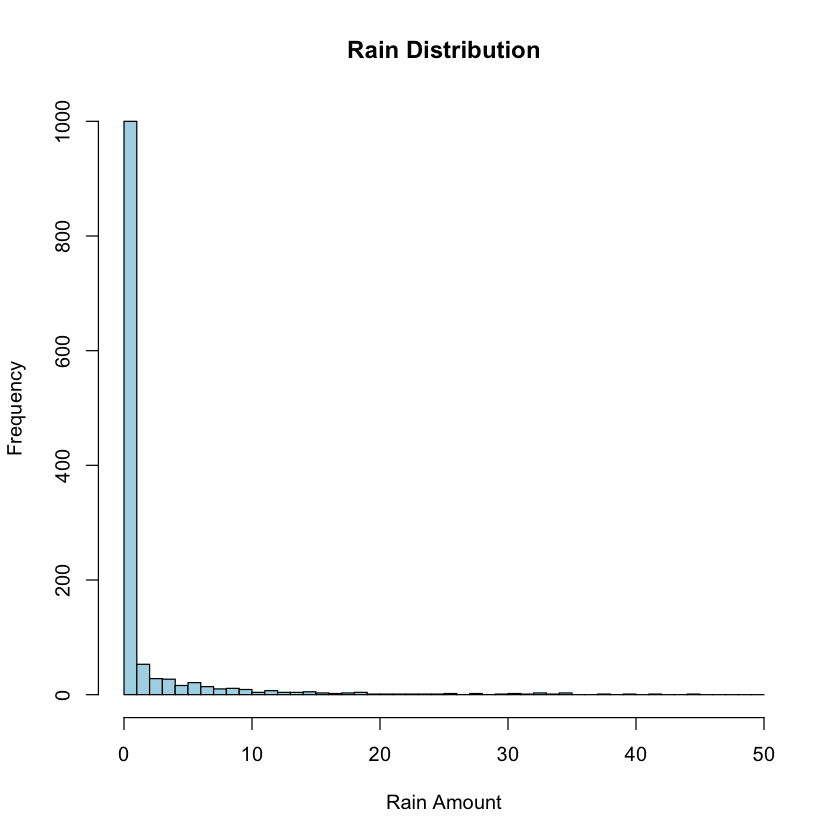

In [69]:
# Histogram custum bins
par(bg = "white")
hist(test_data$rain_amount,
    breaks = seq(0, 50, by = 1),
    main = "Rain Distribution",
    xlab = "Rain Amount",
    ylab = "Frequency",
    col = "lightblue",
    border = "black",
)


### Classification Models Results

Here’s a recap of all the metrics related to the classification models:

| Metric       | Individual Tree | Random Forest |  GLM  | k-NN (k=1) | k-NN (k=19) |
|--------------|-----------------|---------------| ----- | ---------- | ----------- |
| Accuracy (%) | 84.08           | 85.52         | 85.20 | 82.80      | 78.08       |

Among the classification models, Random Forest shows the best performance, closely followed by GLM. Both models outperform others in terms of accuracy. On the other hand, k-NN, especially with k=19, shows the worst performance with a significant drop in accuracy.

### Regression Models Results

| Metric                | Tree - Full |  Tree - Rainy | RF - Full | RF - Rainy |  GLM  | k-NN (k=1) | k-NN (k=19) |
|-----------------------| ----------- | ------------- | ----------| ---------- | ------| ---------- | ----------- |
| RMSE                  | 4.955       | 4.678         | 4.594     | 4.741      | 4.633 | 5.464     | 4.442        |
| Spearman Correlation  | 0.551       | 0.551         | 0.553     | 0.551      | 0.532 | 0.527     | 0.598        |
| Variance Ratio        | 0.561       | 0.618         | 0.448     | 0.619      | 0.761 | 1.063     | 0.307        |

As a first step, I directly exclude the k-NN model because it strongly depends on the number of neighbors. For k=1, it is clearly overfitting, which explains the excessively high Variance Ratio, but this comes with very high errors. On the other hand, with k=19, the RMSE is reasonable, but the Variance Ratio is definitively not competitive.

For the other models, the lowest RMSE is achieved by the Random Forest model trained with all days, followed closely by the GLM. This suggests that these two models better capture the underlying trends in the data. The Decision Tree trained with rainy days only also achieves a similar RMSE; however, this model is highly sensitive to the specific data in the training and test sets. Indeed, different splits of the dataset could lead to significantly different results, indicating that the quality of these results is primarily dependent on how the data is divided between the two sets.

The Spearman correlation remains almost constant across models, except for k-NN with 19 neighbors, where it slightly improves to 0.598. Since the predictors were initially reduced using the Spearman method, the selected features already prioritize monotonic relationships with the target variable. This likely explains why the Spearman correlation shows negligible variation across models.

The Variance Ratio shows the most evident variation among models, where GLM and Random Forest stand out as the best models once again. Additionally, the Decision Tree, trained on rainy days only, appears competitive in terms of RMSE and Variance Ratio. However, as mentioned earlier, this model is highly unstable and particularly sensitive to imbalanced datasets, as in this case, where it tends to fail in generalizing, especially for minority classes. Therefore, given the instability issues associated with decision trees, it is reasonable to exclude this model from consideration as one of the best models.

### Conclusions

For a weather forecast analysis in Lisbon, the most adequate models are Random Forest (especially the “Rainy Days” version) and GLM, as they offer a good balance between accuracy, RMSE, and representation of variance. k-NN, despite achieving a low RMSE with  k=19, should be excluded due to poor performance in classification and lack of robustness. Decision Trees, in particular the one trained with rainy days only, can be used as supporting models, but not as primary ones

For a weather forecast analysis in Lisbon, the most suitable models are Random Forest (especially the Rainy Days version) and GLM, as they provide a good balance between accuracy, RMSE, and variance representation. On the other hand, k-NN, should be excluded due to poor classification performance and a lack of robustness. Decision Trees, particularly the one trained on rainy days only, can serve as supporting models but are not recommended as primary models due to their instability and sensitivity to dataset splits.